## Data Cleaning & Dataframe Prep

This notebook handles the following tasks and prepares the data for the analysis.
If you something off, please fix it and add it to here.

Data Cleaning

- Delete NaN entries.
- Assign 0: Not Applicable to the Empirical Novelty that has been chosen as "Not Applicaple". We have observed that this occurs when reviewers think empirical novelty is not applicaple to a paper, which can be a theoretical one for instance. When calculating the mean of this, please do not include 0 entries.
- Ethics Flags include data which says both NO. and Yes, ... All of the contradictory entries included explanations, so we have accepted them as Yes.
- Delete reviews submitted after the deadline

Data Preparation

- Statistics related to each reviewer is calculated for each paper.
- These statics are: std, mean, diff(max_score-min_score)

### Resulting datasets

- review_df_clean -> reviewer per row cleaned data
- paper_df -> per paper dataframe, statistics are calculated such as mean, std, variance, max_min difference etc.
- df -> basic dataset

In [3]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt

file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

In [4]:
df.columns = df.columns.str.replace("recommendation", "score", regex=False)

### Dataframe 1: Reviewers as rows

In [5]:
# Instead of one row per paper, arrange data to have one reviewer per row.

reviewer_feature_cols = [col.split('reviewer1_')[1] for col in df.columns if col.startswith('reviewer1')]
for i in reviewer_feature_cols:
    print(i)
reviewer_cols = [col for col in df.columns for i in range(1, 5) if col.startswith('reviewer' + str(i) + '_')]
non_reviewer_cols = [col for col in df.columns if col not in reviewer_cols]


df['paper_no'] = np.arange(len(df))
review_df = pd.DataFrame(columns=['paper_id', 'reviewer', 'reviewer_score', 'reviewer_confidence', 'reviewer_summary_of_the_paper', 'reviewer_strength_and_weaknesses', 'reviewer_clarity_quality_novelty_and_reproducibility', 'reviewer_summary_of_the_review', 'reviewer_correctness', 'reviewer_technical_novelty_and_significance', 'reviewer_empirical_novelty_and_significance', 'reviewer_flag_for_ethics_review', 'reviewer_length', 'reviewer_cdate', 'reviewer_tmdate', 'title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate', 'decision'])
for idx, row in df.iterrows():
    for i in range(1, 5):
        dict_ = {}
        for col in reviewer_feature_cols:
            dict_['reviewer'] = i
            dict_['reviewer' + '_' + col] = row['reviewer' + str(i) + '_' + col]
        for col in non_reviewer_cols:
            dict_[col] = row[col]
        dict_['paper_id'] = row['paper_no']
        review_df.loc[len(review_df)] = dict_

df.head()

score
confidence
summary_of_the_paper
strength_and_weaknesses
clarity_quality_novelty_and_reproducibility
summary_of_the_review
correctness
technical_novelty_and_significance
empirical_novelty_and_significance
flag_for_ethics_review
length
cdate
tmdate


,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_no
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,...,I like the proposed approach and its associate...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3082.0,2022-11-03 08:08:39,2022-12-14 03:46:36,Accept: poster,0
1,An Adaptive Entropy-Regularization Framework f...,Multi-Agent Reinforcement Learning; Entropy Re...,This paper proposes an adaptive entropy-regul...,"In this paper, we propose an adaptive entropy-...",2022-09-22 14:33:17,2023-02-14 00:28:54,"3: reject, not good enough","4: You are confident in your assessment, but n...",This paper presents an MARL algorithm to adpat...,### Strengths\n\n1. This paper studies adaptiv...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reject,1
2,AutoSparse: Towards Automated Sparse Training,sparsity; sparse training; deep learning,NaN,Sparse training is emerging as a promising ave...,2022-09-22 14:32:39,2023-02-14 00:29:06,5: marginally below the acceptance threshold,"4: You are confident in your assessment, but n...",This paper first introduces a technique called...,Strengths:\n\n- Provided intuitive examples an...,...,1. The proposed method seems tricky and not el...,2: Several of the paper’s claims are incorrect...,2: The contributions are only marginally signi...,1: The contributions are neither significant n...,NO.,2254.0,2022-10-27 20:14:54,2022-10-27 20:14:54,Reject,2
3,Sampling is as easy as learning the score: the...,diffusion models; score-based generative model...,We prove that given an L2-accurate score estim...,We provide theoretical convergence guarantees ...,2022-09-22 14:40:10,2023-02-14 00:27:00,"8: accept, good paper","4: You are confident in your assessment, but n...",This paper examines the convergence of SGMs un...,Strength:\n\n- The presentation is clear.\n\n-...,...,Overall I think the paper introduces very stro...,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,Not applicable,NO.,5316.0,2022-10-27 22:09:32,2022-10-27 22:09:32,Accept: notable-top-5%,3
4,RoCourseNet: Distributionally Robust Training ...,Counterfactual Explanation; Algorithmic Recour...,NaN,Counterfactual (CF) explanations for machine l...,2022-09-22 14:38:43,2024-11-25 10:12:40,"3: reject, not good enough","4: You are confident in your assessment, but n...",This submission proposed an approach to solvin...,Strength:\n\n1. The paper is easy to follow.\n...,...,The paper solves an important problem. The exp...,4: All of the claims and statements are well-s...,2: The contributions are only marginally signi...,2: The contributions are only marginally signi...,NO.,2937.0,2022-10-29 20:23:57,2022-10-29 20:23:57,Reject,4


### Data prep: convert and simplify column values 

1. Convert cdate to pandas datetime datatype.
2. Add time_to_deadline column which measures the time difference between the review submission and review deadline
3. To get the score part, remove the explanations from score columns such as recommendation.
4. Add a is_high_variance column to detect high discrepancy reviews.
5. There are different acceptances, like top-5-notable etc. We just treat them as expected, so simply those explanations.

In [6]:
df['reviewer1_cdate'] = pd.to_datetime(df['reviewer1_cdate'])
df['reviewer2_cdate'] = pd.to_datetime(df['reviewer2_cdate'])
df['reviewer3_cdate'] = pd.to_datetime(df['reviewer3_cdate'])
df['reviewer4_cdate'] = pd.to_datetime(df['reviewer4_cdate'])

df['reviewer1_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer1_cdate']
df['reviewer2_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer2_cdate']
df['reviewer3_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer3_cdate']
df['reviewer4_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer4_cdate']

df.dropna(subset=['reviewer1_cdate', 'reviewer2_cdate', 'reviewer3_cdate', 'reviewer4_cdate'], inplace=True)

df['reviewer1_score'] = df['reviewer1_score'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer2_score'] = df['reviewer2_score'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer3_score'] = df['reviewer3_score'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer4_score'] = df['reviewer4_score'].apply(lambda x: x.split(':')[0]).astype(int)

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

Play with variables and check if the values are as expected:

In [7]:
df[df['decision'].eq("Accept") & df['is_high_variance']]

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,decision,paper_no,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_score,min_score,max_min_score_diff,is_high_variance
32,PD-MORL: Preference-Driven Multi-Objective Rei...,multi-objective reinforcement learning; MORL; ...,A novel approach that obtains a single policy ...,Multi-objective reinforcement learning (MORL) ...,2022-09-22 14:37:04,2023-03-02 03:46:32,8,3: You are fairly confident in your assessment...,This work proposes an algorithm for solving mu...,The main strengths of this paper:\n- Novel app...,...,Accept,32,11 days 07:56:58,10 days 08:47:26,8 days 00:55:32,2 days 05:53:11,8,3,5,True
33,CircNet: Meshing 3D Point Clouds with Circumce...,Meshing; 3D Point Cloud; Point Cloud Triangula...,We present a deep neural architecture that det...,Reconstructing 3D point clouds into triangle m...,2022-09-22 14:34:26,2024-11-25 10:14:38,8,"4: You are confident in your assessment, but n...",This paper tackles the problem of point cloud ...,Strength\n+ The formulation of the problem as ...,...,Accept,33,15 days 11:46:51,13 days 09:18:49,0 days 01:53:56,-2 days +00:26:53,8,3,5,True
34,Semi-supervised learning with a principled lik...,Bayesian deep learning; Bayesian neural networ...,"We develop Bayesian semi-supervised learning, ...",We currently do not have an understanding of s...,2022-09-22 14:34:48,2023-02-21 09:35:10,5,"4: You are confident in your assessment, but n...",The authors consider the fact that our common ...,## Strengths\nThe paper is well argued for and...,...,Accept,34,16 days 15:04:34,10 days 04:45:05,10 days 01:48:15,7 days 20:28:22,8,3,5,True
37,Is Adversarial Training Really a Silver Bullet...,Data poisoning; adversarial training; indiscri...,We propose an indiscriminative feature-based p...,Indiscriminate data poisoning can decrease the...,2022-09-22 14:36:10,2023-03-02 17:30:28,6,"4: You are confident in your assessment, but n...",In this work the authors attack in models in t...,Strengths:\n* The method is novel and obtains ...,...,Accept,37,11 days 15:48:46,11 days 07:24:56,10 days 03:36:11,7 days 22:02:29,10,6,4,True
55,Red PANDA: Disambiguating Image Anomaly Detect...,Anomaly Detection; Disentanglement,Proposing a new anomaly detection setting when...,Anomaly detection methods strive to discover p...,2022-09-22 14:35:53,2023-03-02 12:44:02,6,3: You are fairly confident in your assessment...,This paper concerns anomaly detection. In part...,# Strengths\n* Anomaly detection is an interes...,...,Accept,55,15 days 13:28:45,9 days 21:32:44,8 days 18:47:58,4 days 10:41:23,6,1,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,DDM$^2$: Self-Supervised Diffusion MRI Denoisi...,Unsupervised MRI Denoising; Diffusion Models,NaN,Magnetic resonance imaging (MRI) is a common a...,2022-09-22 14:31:21,2024-11-25 10:16:17,1,5: You are absolutely certain about your asses...,The paper proposes a new method for denoising ...,Strengths\n\nThe proposed method makes use of ...,...,Accept,3678,10 days 21:33:32,10 days 13:51:50,3 days 20:27:53,3 days 11:06:24,8,1,7,True
3743,SeaFormer: Squeeze-enhanced Axial Transformer ...,NaN,NaN,"Since the introduction of Vision Transformers,...",2022-09-22 14:32:03,2024-11-25 10:15:52,8,"2: You are willing to defend your assessment, ...",this paper presents SeaFormer: a new transform...,Strength:\n- The proposed transformer is O(WH)...,...,Accept,3743,11 days 16:43:04,11 days 10:33:00,10 days 21:16:35,10 days 13:05:09,8,3,5,True
3746,Neural Image-based Avatars: Generalizable Radi...,Generalizable human radiance fields; Human per...,NaN,We present a method that enables synthesizing ...,2022-09-22 14:41:21,2024-11-25 10:11:30,8,3: You are fairly confident in your assessment...,The authors propose Neural Image-based Avatars...,Main Stre

In [8]:
df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']]

,reviewer1_score,reviewer2_score,reviewer3_score,reviewer4_score
0,6,8,6,6
2,5,6,3,3
3,8,8,8,8
4,3,3,3,6
5,6,6,3,3
...,...,...,...,...
3789,6,6,6,6
3790,3,3,3,3
3792,1,6,6,3
3793,6,6,8,6


### Data Cleaning

1. Clean reviews submitted after the deadline

In [9]:
review_df['reviewer_cdate'] = pd.to_datetime(review_df['reviewer_cdate'])
review_df_clean = review_df[review_df['reviewer_cdate'] < pd.to_datetime('2022-11-05 01:00:00')]
review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/3064297660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)


2. Treat contradictiory ethis flags as Yes, because all of them include explanation.

In [10]:
review_df_clean.value_counts('reviewer_flag_for_ethics_review')
review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/2241807063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)


3. Assign 0 to Not applicaple papers for Empirical Novelty and Significance. These are generally treated as theoretical papers by the reviewers.

In [11]:
print(review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts())
review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)
review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts()

review_df_clean.reset_index(drop=True, inplace=True)

reviewer_empirical_novelty_and_significance
3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.    5895
2: The contributions are only marginally significant or novel.                                              5270
Not applicable                                                                                              1075
4: The contributions are significant, and do not exist in prior works.                                      1018
1: The contributions are neither significant nor novel.                                                      621
Name: count, dtype: int64


/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/2876056155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)


4. Add time_to_deadline column

In [12]:
review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/2658128959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']


5. Convert string numbers to integers.

In [13]:
review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)

review_df_clean['review_score'] = review_df_clean['reviewer_score'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_score'], inplace=True)

review_df_clean['review_correctness'] = review_df_clean['reviewer_correctness'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_correctness'], inplace=True)

review_df_clean['review_technical_novelty_and_significance'] = review_df_clean['reviewer_technical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_technical_novelty_and_significance'], inplace=True)

review_df_clean['review_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_empirical_novelty_and_significance'], inplace=True)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/3490803434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/3490803434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/3490803434.py:4: SettingW

In [14]:
def score_variance(row):
    scores = []
    # Check each reviewer score column; ignore NaNs
    for col in ["reviewer1_score", "reviewer2_score", "reviewer3_score", "reviewer4_score"]:
        val = row[col]
        if pd.notna(val):
            scores.append(val)
    # Compute variance (or std) of these scores if they exist
    if len(scores) > 1:
        return np.var(scores, ddof=1)  # sample variance
    else:
        return 0.0  # or np.nan, if only one valid score

df["score_variance"] = df.apply(score_variance, axis=1)
df["score_variance"]

0       1.00
2       2.25
3       0.00
4       2.25
5       3.00
        ... 
3789    0.00
3790    0.00
3792    6.00
3793    1.00
3794    2.25
Name: score_variance, Length: 2628, dtype: float64

Global Keyword Frequencies:
               keyword  global_freq
0       reinforcement          319
35              graph          231
29     representation          208
138          language          174
32       optimization          161
...               ...          ...
1542      deformation            1
1539           linker            1
1529  non-assortative            1
1528           degree            1
2820              bev            1

[2821 rows x 2 columns]

Correlation between popularity_score and acceptance (1=Accept, 0=Reject): 0.022895196152442513


<Figure size 600x400 with 0 Axes>

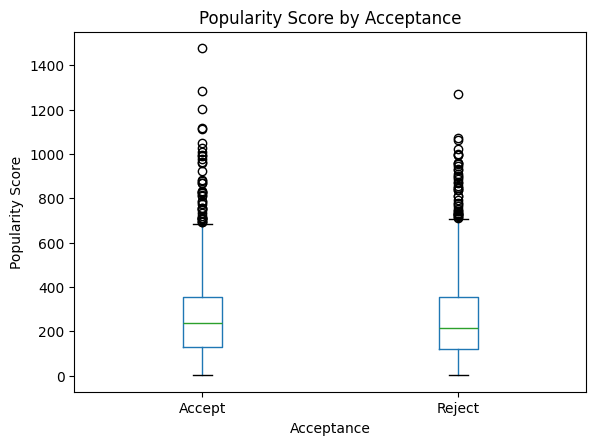

In [15]:
from collections import Counter
# Find the popularity score of the most popular and least popular papers in each cluster
# =================================
# 2. Clean and Normalize Keywords
# =================================
def split_and_normalize(kw_string):
    if pd.isna(kw_string):
        return []
    tokens = kw_string.split(";")
    
    tokens = [t.split(' ') for t in tokens]
    tokens = [item for sublist in tokens for item in sublist if item != '' and \
                                                                            item.strip().lower() != 'learning' \
                                                                            and item.strip().lower() != 'deep' \
                                                                            and item.strip().lower() != 'neural' \
                                                                            and item.strip().lower() != 'networks' \
                                                                            and item.strip().lower() != 'network' \
                                                                            and item.strip().lower() != 'model' \
                                                                            and item.strip().lower() != 'models' \
                                                                            and item.strip().lower() != 'data' \
                                                                            and item.strip().lower() != 'machine' \
                                                                            and item.strip().lower() != 'generation' \
                                                                            and item.strip().lower() != 'vision' \
                                                                            ]
    return [t.strip().lower() for t in tokens if t.strip()]


# extract the raw that are keywords are nan
df.dropna(subset=['keywords'], inplace=True)


df["keyword_list"] = df["keywords"].apply(split_and_normalize)


# =================================
# 3. Compute Global Keyword Frequencies
# =================================
all_keywords = []

for kw_list in df["keyword_list"]:
    all_keywords.extend(kw_list)
freq_counter = Counter(all_keywords)

# Optional: see the frequencies
freq_df = pd.DataFrame(freq_counter.items(), columns=["keyword", "global_freq"])
freq_df.sort_values("global_freq", ascending=False, inplace=True)
print("Global Keyword Frequencies:\n", freq_df)

# =================================
# 4. Popularity Score for Each Paper
# =================================
def compute_popularity_score(kw_list):
    return sum(freq_counter[k] for k in kw_list)

df["popularity_score"] = df["keyword_list"].apply(compute_popularity_score)

# =================================
# 5. Convert Acceptance to Numeric
# =================================
#  "Accept" -> 1, "Reject" -> 0
df["acceptance_num"] = df["decision"].map({"Accept": 1, "Reject": 0})

# =================================
# 6. Correlation
# =================================
corr = df["popularity_score"].corr(df["acceptance_num"])
print("\nCorrelation between popularity_score and acceptance (1=Accept, 0=Reject):", corr)

# =================================
# 7. (Optional) Visualization
# =================================
# A quick boxplot or scatter might help too:
plt.figure(figsize=(6,4))
df.boxplot(column="popularity_score", by="decision", grid=False)
plt.title("Popularity Score by Acceptance")
plt.suptitle("")  # remove default title
plt.xlabel("Acceptance")
plt.ylabel("Popularity Score")
plt.show()

In [16]:
print("Global Keyword Frequencies:\n", freq_df.head(20))

Global Keyword Frequencies:
              keyword  global_freq
0      reinforcement          319
35             graph          231
29    representation          208
138         language          174
32      optimization          161
67    generalization          127
20       adversarial          121
51            theory          116
22        robustness          109
105  self-supervised          101
201        federated           98
209      transformer           96
8         generative           93
5           training           89
164            image           88
6          diffusion           79
37         detection           77
216      contrastive           71
40    classification           69
44         knowledge           67


/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/240205959.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/240205959.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


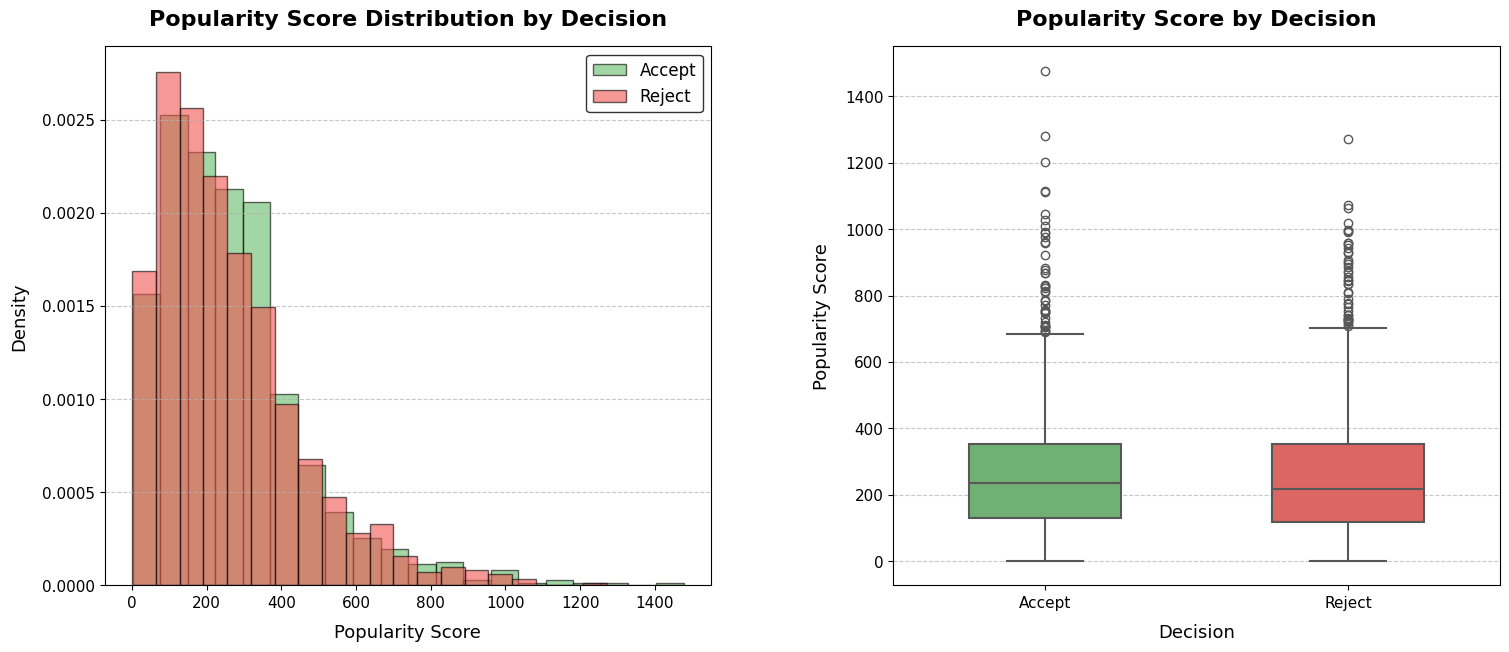

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is your dataframe
accept_scores = df[df["decision"] == "Accept"]["popularity_score"]
reject_scores = df[df["decision"] == "Reject"]["popularity_score"]

# Define a custom color palette
colors = {"Accept": "#66BB6A", "Reject": "#EF5350"}  # Slightly softer green and red

# Create a figure for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'wspace': 0.3})

# Plot 1: Normalized Overlapping Histograms
bins = 20
axes[0].hist(
    accept_scores, bins=bins, alpha=0.6, label="Accept", color=colors["Accept"], edgecolor="black", density=True
)
axes[0].hist(
    reject_scores, bins=bins, alpha=0.6, label="Reject", color=colors["Reject"], edgecolor="black", density=True
)
axes[0].set_title("Popularity Score Distribution by Decision", fontsize=16, fontweight="bold", pad=15)
axes[0].set_xlabel("Popularity Score", fontsize=13, labelpad=10)
axes[0].set_ylabel("Density", fontsize=13, labelpad=10)
axes[0].tick_params(axis="both", which="major", labelsize=11)
axes[0].legend(fontsize=12, loc="upper right", frameon=True, facecolor="white", edgecolor="black")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)  # Add gridlines for better readability

# Plot 2: Box Plot with Annotations
sns.boxplot(
    data=df, 
    x="decision", 
    y="popularity_score", 
    palette=colors, 
    ax=axes[1], 
    width=0.5, 
    linewidth=1.5
)

# Add median and IQR annotations to the box plot
for i, box in enumerate(axes[1].artists):
    y_values = df[df["decision"] == box.get_label()]["popularity_score"]
    median = y_values.median()
    q1, q3 = y_values.quantile([0.25, 0.75])
    axes[1].text(
        i, median, f"Median: {median:.1f}", ha="center", va="center", fontsize=10, color="black", weight="bold"
    )
    axes[1].text(
        i, q1, f"Q1: {q1:.1f}", ha="center", va="center", fontsize=10, color="black", alpha=0.7
    )
    axes[1].text(
        i, q3, f"Q3: {q3:.1f}", ha="center", va="center", fontsize=10, color="black", alpha=0.7
    )

axes[1].set_title("Popularity Score by Decision", fontsize=16, fontweight="bold", pad=15)
axes[1].set_xlabel("Decision", fontsize=13, labelpad=10)
axes[1].set_ylabel("Popularity Score", fontsize=13, labelpad=10)
axes[1].tick_params(axis="both", which="major", labelsize=11)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)  # Add gridlines for better readability

# Improve spacing and layout
plt.tight_layout()
plt.show()


In [18]:

from scipy.stats import ttest_ind

accept_scores = df[df["decision"] == "Accept"]["popularity_score"]
reject_scores = df[df["decision"] == "Reject"]["popularity_score"]

t_stat, p_value = ttest_ind(accept_scores, reject_scores, equal_var=False)  # Welch's t-test
print("t-statistic:", t_stat, "p-value:", p_value)

t-statistic: 1.083162499223805 p-value: 0.2788644568962801


In [19]:
from scipy.stats import mannwhitneyu

accepted_scores = df.loc[df["acceptance_num"] == 1, "popularity_score"]
rejected_scores = df.loc[df["acceptance_num"] == 0, "popularity_score"]

u_stat, p_value = mannwhitneyu(accepted_scores, rejected_scores, alternative='two-sided')
print("U-statistic:", u_stat, "p-value:", p_value)


U-statistic: 643738.5 p-value: 0.18380825082012142


In [20]:
import statsmodels.api as sm

X = df["popularity_score"]
y = df["acceptance_num"]

X_with_intercept = sm.add_constant(X)  # add intercept
model = sm.Logit(y, X_with_intercept).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.681906
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         acceptance_num   No. Observations:                 2258
Model:                          Logit   Df Residuals:                     2256
Method:                           MLE   Df Model:                            1
Date:                Tue, 04 Feb 2025   Pseudo R-squ.:               0.0003831
Time:                        13:37:05   Log-Likelihood:                -1539.7
converged:                       True   LL-Null:                       -1540.3
Covariance Type:            nonrobust   LLR p-value:                    0.2773
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3610      0.072     -5.014      0.000      -0.502      -0.220
popularity_

In [21]:
df['max_min_score_diff'].corr(df['popularity_score'])

np.float64(0.004351033567973206)

## Comparison betweeen popularity and max_min_score 

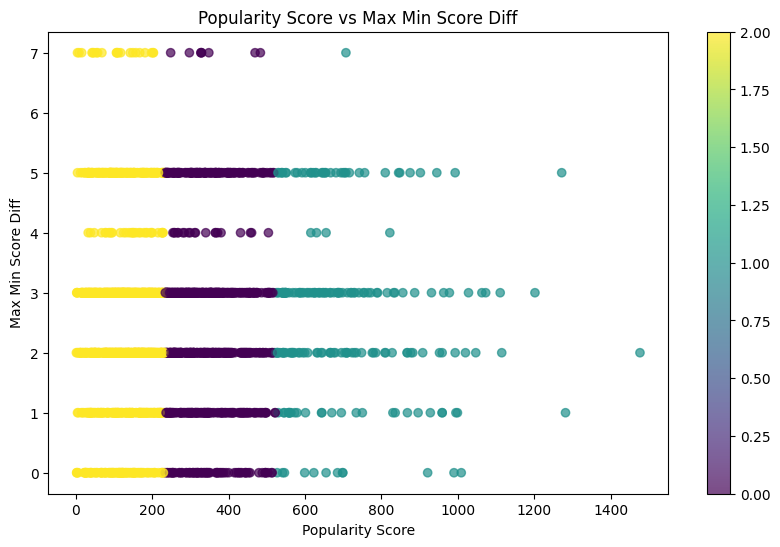

In [22]:
# cluster the papers according to their popularity score df['popularity_score']
from sklearn.cluster import KMeans

X = df[['popularity_score']]


# Unpopular papers (0), Moderately Popular papers (1), Popular papers (2)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['popularity_cluster'] = kmeans.labels_

df['popularity_cluster'].value_counts()


# check the max_min_score_diff for each cluster and see if there is a difference between the clusters plot and also write the max pop score and min pop score for each cluster
plt.figure(figsize=(10,6))
plt.scatter(df['popularity_score'], df['max_min_score_diff'], c=df['popularity_cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Popularity Score')
plt.ylabel('Max Min Score Diff')
plt.title('Popularity Score vs Max Min Score Diff')
plt.colorbar()
plt.show()





/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_47772/369749184.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


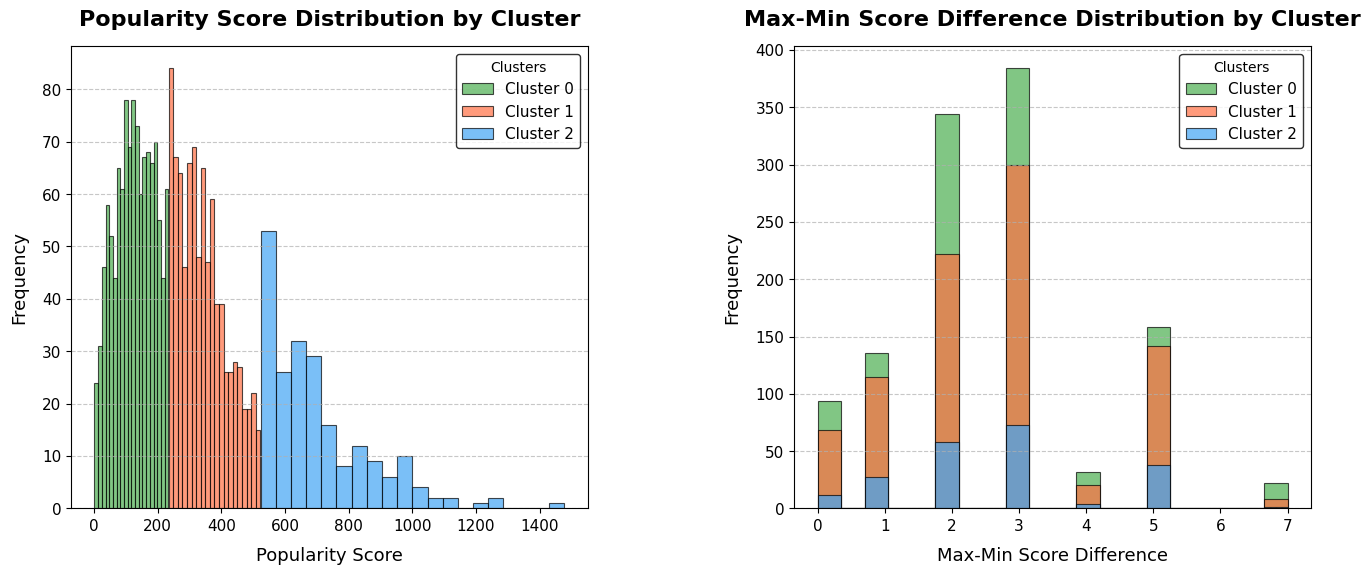

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom color palette for clusters
cluster_colors = {2: "#4CAF50", 0: "#FF7043", 1: "#42A5F5"}  # Blue, Orange, Green


# Ensure clusters are ordered consistently: Cluster 0 (left), Cluster 1 (middle), Cluster 2 (right)
sorted_clusters = [2, 0, 1]


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.4})

# Plot 1: Popularity Score Histograms by Cluster
for idx,cluster_id in enumerate(sorted_clusters):
    subset = df[df['popularity_cluster'] == cluster_id]['popularity_score']
    axes[0].hist(
        subset, bins=20, alpha=0.7, label=f"Cluster {idx}",
        color=cluster_colors[cluster_id], edgecolor="black", linewidth=0.8
    )
axes[0].set_title("Popularity Score Distribution by Cluster", fontsize=16, fontweight="bold", pad=15)
axes[0].set_xlabel("Popularity Score", fontsize=13, labelpad=10)
axes[0].set_ylabel("Frequency", fontsize=13, labelpad=10)
axes[0].tick_params(axis="both", which="major", labelsize=11)
axes[0].legend(title="Clusters", fontsize=11, loc="upper right", frameon=True, facecolor="white", edgecolor="black")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot 2: Max-Min Score Diff Histograms by Cluster
for idx,cluster_id in enumerate(sorted_clusters):
    subset = df[df['popularity_cluster'] == cluster_id]['max_min_score_diff']
    axes[1].hist(
        subset, bins=20, alpha=0.7, label=f"Cluster {idx}",
        color=cluster_colors[cluster_id], edgecolor="black", linewidth=0.8
    )
axes[1].set_title("Max-Min Score Difference Distribution by Cluster", fontsize=16, fontweight="bold", pad=15)
axes[1].set_xlabel("Max-Min Score Difference", fontsize=13, labelpad=10)
axes[1].set_ylabel("Frequency", fontsize=13, labelpad=10)
axes[1].tick_params(axis="both", which="major", labelsize=11)
axes[1].legend(title="Clusters", fontsize=11, loc="upper right", frameon=True, facecolor="white", edgecolor="black")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()


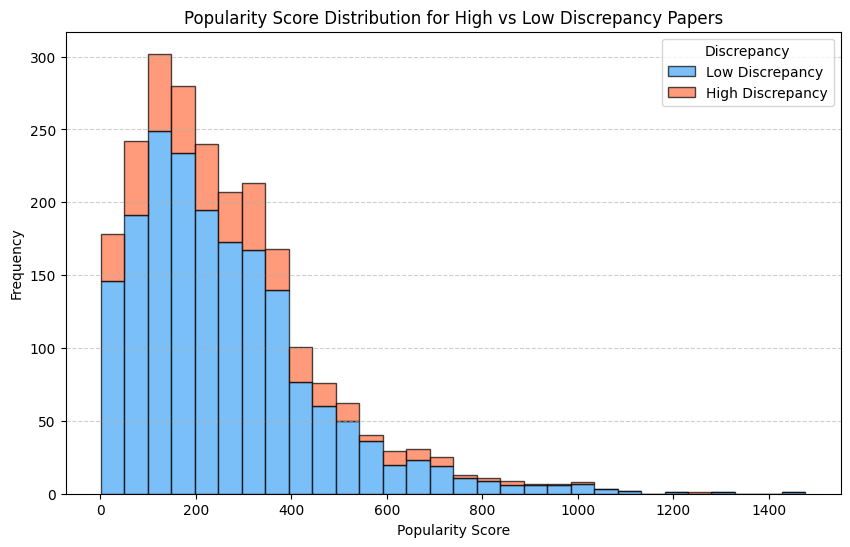

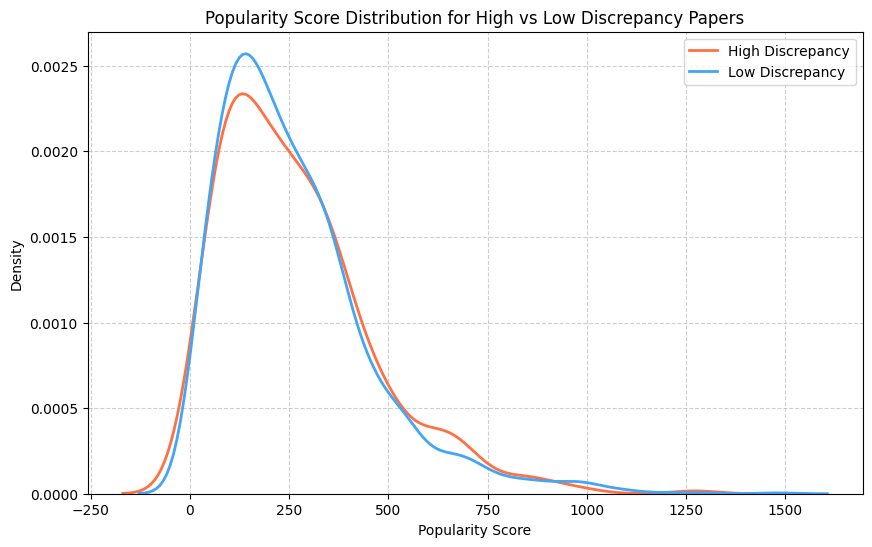

In [25]:
import matplotlib.pyplot as plt

# Provided color palette
cluster_colors = {2: "#4CAF50", 0: "#FF7043", 1: "#42A5F5"}  # Green, Orange, Blue

plt.figure(figsize=(10, 6))
high_discreapency_paper = df[df['max_min_score_diff'] >= 4]
low_discreapency_paper = df[df['max_min_score_diff'] < 4]

# Plot normalized (density) histograms as step plots to avoid fill-overlap
plt.hist(high_discreapency_paper['popularity_score'],
         bins=20,
         density=True,
         histtype='step',
         linewidth=2,
         label='High Discreapency',
         color=cluster_colors[0])

plt.hist(low_discreapency_paper['popularity_score'],
         bins=20,
         density=True,
         histtype='step',
         linewidth=2,
         label='Low Discreapency',
         color=cluster_colors[1])

plt.xlabel("Popularity Score")
plt.ylabel("Density")
plt.title("Popularity Score Distribution for High vs Low Discreapency Papers")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [24]:
from scipy.stats import f_oneway, kruskal

# Split max_min_score_diff by cluster
cluster_groups = [df[df['popularity_cluster'] == c]['max_min_score_diff'] 
                  for c in sorted(df['popularity_cluster'].unique())]

# # 1. One-way ANOVA
# f_stat, p_anova = f_oneway(*cluster_groups)
# print("ANOVA: F-stat =", f_stat, "p-value =", p_anova)

# 2. Kruskal-Wallis test (non-parametric)
h_stat, p_kw = kruskal(*cluster_groups)
print("Kruskal-Wallis: H-stat =", h_stat, "p-value =", p_kw)


ANOVA: F-stat = 0.3968927248928833 p-value = 0.6724531159990998
Kruskal-Wallis: H-stat = 1.2733727109294206 p-value = 0.5290425818013953


Pearson correlation between popularity score and max-min diff: 0.0044
Spearman correlation between popularity score and max-min diff: 0.0107
KMeans cluster centers: [[342.21942857]
 [702.80373832]
 [124.59709153]]
Cluster 0:
  Size = 875
  Popularity Score Range = [234, 522]
  Mean Max–Min Diff = 2.63

Cluster 1:
  Size = 213
  Popularity Score Range = [523, 1477]
  Mean Max–Min Diff = 2.70

Cluster 2:
  Size = 1170
  Popularity Score Range = [1, 233]
  Mean Max–Min Diff = 2.61



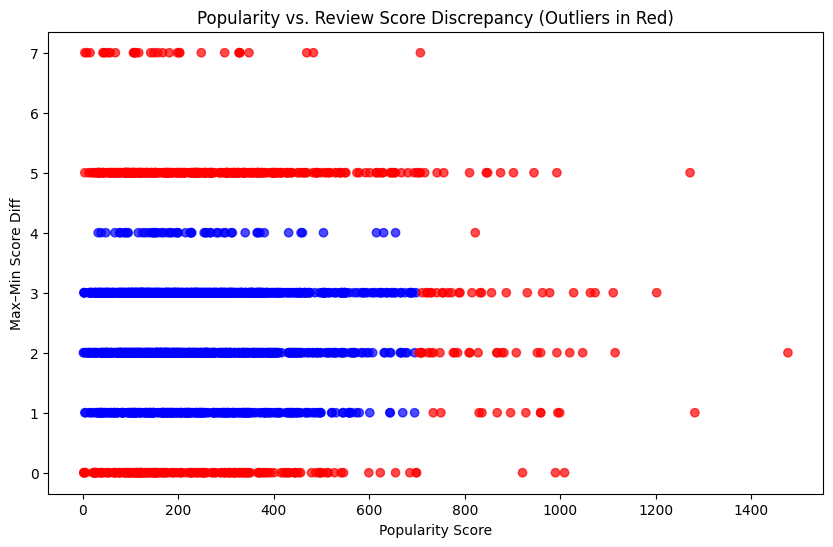

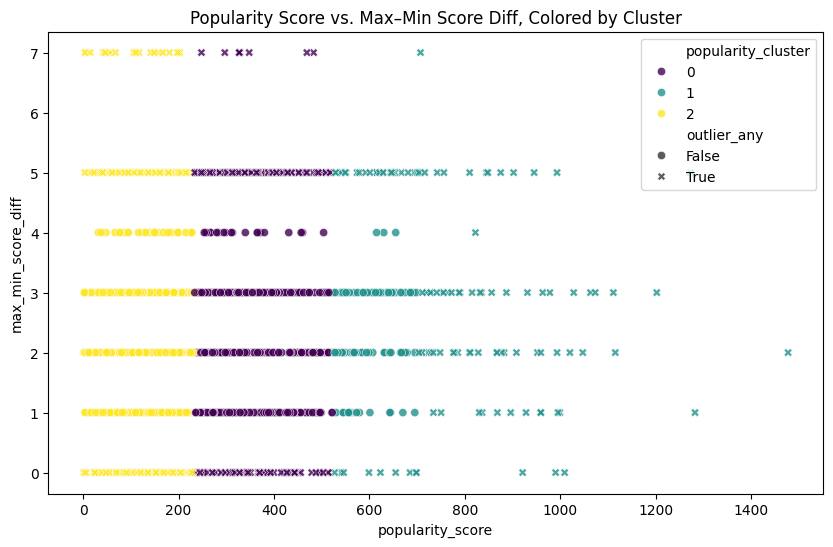

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter

#########################################
# 1. Compute Correlations
#########################################

pearson_corr = df['popularity_score'].corr(df['max_min_score_diff'], method='pearson')
spearman_corr = df['popularity_score'].corr(df['max_min_score_diff'], method='spearman')

print(f"Pearson correlation between popularity score and max-min diff: {pearson_corr:.4f}")
print(f"Spearman correlation between popularity score and max-min diff: {spearman_corr:.4f}")

#########################################
# 2. Identify Outliers (IQR method)
#########################################

# Outliers in Max–Min Score Diff
Q1_diff = df['max_min_score_diff'].quantile(0.25)
Q3_diff = df['max_min_score_diff'].quantile(0.75)
IQR_diff = Q3_diff - Q1_diff
upper_diff = Q3_diff + 1.5 * IQR_diff
lower_diff = Q1_diff - 1.5 * IQR_diff  # often less relevant if it can't go below 0

df['outlier_diff'] = (df['max_min_score_diff'] > upper_diff) | (df['max_min_score_diff'] < lower_diff)

# Outliers in Popularity Score
Q1_pop = df['popularity_score'].quantile(0.25)
Q3_pop = df['popularity_score'].quantile(0.75)
IQR_pop = Q3_pop - Q1_pop
upper_pop = Q3_pop + 1.5 * IQR_pop
lower_pop = Q1_pop - 1.5 * IQR_pop

df['outlier_pop'] = (df['popularity_score'] > upper_pop) | (df['popularity_score'] < lower_pop)

# Points that are outliers in either dimension
df['outlier_any'] = df['outlier_diff'] | df['outlier_pop']

#########################################
# 3. Report Cluster-Wise Statistics
#########################################

# If you haven't already fit KMeans, do it here:
# X = df[['popularity_score']]
# kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
# df['popularity_cluster'] = kmeans.labels_

# Show cluster centers (for popularity_score only)
print("KMeans cluster centers:", kmeans.cluster_centers_)

# For each cluster, print size, min/max popularity, avg max-min diff
for cluster_id in sorted(df['popularity_cluster'].unique()):
    cluster_data = df[df['popularity_cluster'] == cluster_id]
    size = len(cluster_data)
    min_pop = cluster_data['popularity_score'].min()
    max_pop = cluster_data['popularity_score'].max()
    avg_diff = cluster_data['max_min_score_diff'].mean()
    print(f"Cluster {cluster_id}:")
    print(f"  Size = {size}")
    print(f"  Popularity Score Range = [{min_pop}, {max_pop}]")
    print(f"  Mean Max–Min Diff = {avg_diff:.2f}\n")

#########################################
# 4. (Optional) Acceptance Rates by Cluster
#########################################
# If you have a column "accepted" (True/False or 1/0), you can do:
if 'accepted' in df.columns:
    for cluster_id in sorted(df['popularity_cluster'].unique()):
        cluster_data = df[df['popularity_cluster'] == cluster_id]
        acceptance_rate = cluster_data['accepted'].mean() * 100
        print(f"Cluster {cluster_id} acceptance rate: {acceptance_rate:.2f}%")

#########################################
# 5. Visualize Outliers in the Scatter Plot
#########################################

# Color points differently if they're outliers
colors = np.where(df['outlier_any'], 'red', 'blue')

plt.figure(figsize=(10,6))
plt.scatter(df['popularity_score'], df['max_min_score_diff'], c=colors, alpha=0.7)
plt.xlabel('Popularity Score')
plt.ylabel('Max–Min Score Diff')
plt.title('Popularity vs. Review Score Discrepancy (Outliers in Red)')
plt.show()

# Alternatively, you can color by cluster and highlight outliers separately:
# color by cluster; highlight shape or alpha if outlier
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='popularity_score',
    y='max_min_score_diff',
    hue='popularity_cluster',  # color by cluster
    style='outlier_any',       # different marker if outlier
    palette='viridis',
    alpha=0.8
)
plt.title("Popularity Score vs. Max–Min Score Diff, Colored by Cluster")
plt.show()


1. Near‐Zero Correlation
Both the Pearson and Spearman correlations between popularity_score and max_min_score_diff are effectively zero. This tells you that, across all papers, there is no strong linear or even monotonic relationship between how “popular” a paper’s keywords are and how far apart its review scores end up being. In other words, at a global level:

Having more common keywords does not necessarily make a paper more (or less) polarizing.

2. Clustering Findings
You divided the papers into five KMeans clusters based on popularity score. The cluster “centers” (92.7, 231.4, 381.7, 602.4, 957.8) simply reflect where KMeans decided to partition the data on the popularity axis. For each cluster, you looked at:

Size: How many papers fall into this popularity range
Popularity Score Range: The min/max of popularity_score
Mean Max–Min Score Diff: The average disparity in reviewer scores within that group
Observations
Cluster 2 (lowest popularity range) is actually the largest cluster (742 papers). Its mean review spread is 2.65, which is on the higher side.
Cluster 3 (popularity ~500–800) has the highest average review spread at 2.72, despite being only moderate‐high popularity.
Cluster 4 (highest popularity, ~800–1500) is actually the smallest cluster (55 papers) but has the lowest average review spread (2.45).
Putting that all together:

It’s not as simple as “more popularity = bigger or smaller review gaps.”

In fact, the group of highest‐popularity papers has the lowest average reviewer disagreement. Meanwhile, the next‐highest group (Cluster 3) exhibits the highest average disagreement.

3. How to Interpret This
No Single Trend in the Whole Dataset
Because correlation is near zero, there’s no universal rule that high‐popularity = high/low review spread. Instead, you see pockets of the data (the clusters) that behave differently.

Possible Explanations

Cluster 4 (papers with very high popularity scores) might be pulling from very established keywords or “hot” areas where reviewers share common expectations or acceptance criteria—leading to more consensus (lower average spread). However, it could also be that there are fewer such submissions (only 55 papers), so with smaller 
𝑛
n, you may see less variance.
Cluster 3 (slightly lower popularity than Cluster 4, but still high) may be a “mixed bag” of topics or subfields that have not reached a consensus in the community—hence more frequent disagreements.
Check Within‐Cluster Variance
Although you looked at the mean of the max_min_score_diff in each cluster, there could be a lot of variability within each group.

You might want to plot histograms (or boxplots) of max_min_score_diff per cluster to see if certain clusters have bimodal or wide distributions.
Statistical Testing
If you really want to see whether the differences in mean spread among the clusters are statistically significant, you could:

Perform an ANOVA or Kruskal‐Wallis test on max_min_score_diff grouped by cluster.
Follow up with pairwise post‐hoc tests if you find a significant difference.
4. Further Directions
Look at Specific Keywords

Within each cluster, identify the most frequent keywords. Are certain research areas more prone to polarized reviews?
Acceptance Rates

If you have the acceptance/rejection info, compare acceptance rates by cluster. High‐popularity clusters sometimes have higher acceptance but might also be very competitive.
Paper Length or Submission Type

You could see if shorter submissions or certain track types (oral/spotlight/poster) have higher or lower spread.
Reviewer/Author Overlaps

Sometimes more “popular” topics get assigned to many specialists, which might reduce disagreement. Or it could increase disagreement if it’s a highly debated subfield. Checking that would require more detailed data on reviewer backgrounds, though.
In Summary
No straight‐line relationship in the entire dataset.
Highest‐popularity group has the lowest average review spread—though sample size is small.
Moderate‐high popularity group appears the most controversial on average.
Clustering your data by “keyword popularity” uncovered these subtleties that a simple correlation could miss.
Next, you could:

Drill down to see exactly which keywords and papers are in each cluster.
Validate whether these differences (like 2.45 vs. 2.72 in mean spread) are meaningful and statistically significant.
Overlay acceptance decisions or additional metadata to see whether popularity + review spread translates to different acceptance outcomes.